In [1]:
# objective : detecting suspicious communication specificly (cyber bulling, threatning, terirosim ) from any type of txt data

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nltk
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

import re, os
for dirname, _, filenames in os.walk('data/dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data/dataset/nytimes.csv
data/dataset/suspicious-tweets.csv
data/dataset/result.csv
data/dataset/guardian.csv


In [3]:
df = pd.read_csv('data/dataset/suspicious-tweets.csv')

df.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
0        6145   6133  being sick really sucks!  Especailly since thi...    2
1       53855  53574                                @reatlas  Clean Me!    7

In [4]:
# Count the number of characters in each message
df['length'] = df['message'].apply(len)
df.head()

,message,label,length
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",1,115
1,is upset that he can't update his Facebook by ...,1,111
2,@Kenichan I dived many times for the ball. Man...,1,89
3,my whole body feels itchy and like its on fire,0,47
4,"@nationwideclass no, it's not behaving at all....",1,111


In [34]:
# Use for pre-test only 11 number of elements!
df_labels = df['label']
df_labels.head()

0    1
1    1
2    1
3    0
4    1
Name: label, dtype: int64

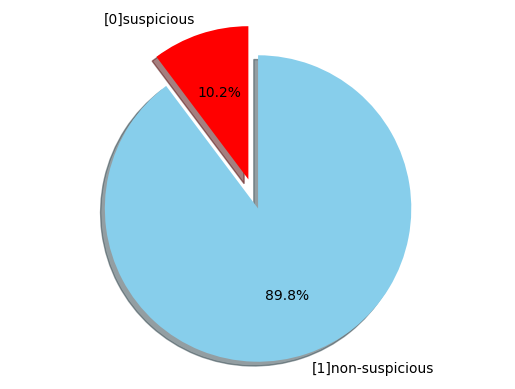

In [6]:
# Only for hinstogram
count_Class = pd.value_counts(df.label, sort = True)

# Data
# 0 = suspicious
# 1 = non-suspicious
labels = '[0]suspicious', '[1]non-suspicious'
sizes = [count_Class[0], count_Class[1]]
colors = ['red', 'skyblue']
explode = (0.1, 0.1)


plt.pie(sizes, explode = explode, labels = labels, colors = colors,
        autopct = '%1.1f%%', shadow = True, startangle = 90)
plt.axis('equal')
plt.show()

In [7]:
# Preprocess text and clean string
def preprocess_text(sen):
    sentence = re.sub('(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)',' ',sen) # Removing html tags
    sentence = re.sub('[^a-zA-Z]', ' ', sentence) # Remove punctuations and numbers
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence) # Single character removal
    sentence = re.sub(r'\s+', ' ', sentence) # Removing multiple spaces
    sentence = sentence.replace("ain't", "am not").replace("aren't", "are not")
    sentence = ' '.join(text.lower() for text in sentence.split(' ')) # Lowering cases
    sw = stopwords.words('english')
    sentence = ' '.join(text for text in sentence.split() if text not in sw) #removing stopwords
    #sentence = ' '.join(text.lemmatize() for text in sentence.split()) #lemmatization
    return sentence

In [35]:
# Save in message, clean text
df['message'] = df.message.apply(preprocess_text)
# Tokenization each text
df['message'] = df['message'].apply(nltk.word_tokenize)

# The Porter stemming algorithm (or 'Porter stemmer') is a process for removing the commoner morphological 
# and inflexional endings from words in English. Its main use is as part of a term normalisation process that 
# is usually done when setting up Information Retrieval systems.
stemmer = PorterStemmer()
df['message'] = df['message'].apply(lambda x: [stemmer.stem(y) for y in x])

0        [switchfoot, bummer, shoulda, got, david, carr...
1                           [upset, updat, facebook, text]
2        [kenichan, dive, mani, time, ball, manag, save...
3                   [whole, bodi, feel, itchi, like, fire]
4                       [nationwideclass, behav, mad, see]
                               ...                        
59995    [realli, want, go, see, zac, efron, amazingli,...
59996                                      [krissa, thank]
59997                                              [dream]
59998         [theellenshow, saw, clip, onlin, good, show]
59999                     [msdivineknight, hun, worri, xx]
Name: message, Length: 60000, dtype: object

In [9]:
# is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!
# -> ['upset', 'updat', 'facebook', 'text', 'might', 'cri', 'result', 'school', 'today', 'blah']
show = df['message']
show.head()

0    [switchfoot, bummer, shoulda, got, david, carr...
1                       [upset, updat, facebook, text]
2    [kenichan, dive, mani, time, ball, manag, save...
3               [whole, bodi, feel, itchi, like, fire]
4                   [nationwideclass, behav, mad, see]
Name: message, dtype: object

In [10]:
df['message'] = df['message'].apply(lambda x: ' '.join(x))

# Convert a collection of text documents to a matrix of token counts.
count_vect = CountVectorizer()
counts = count_vect.fit_transform(df['message']);

In [11]:
transformer = TfidfTransformer().fit(counts)
counts = transformer.fit_transform(counts)

In [12]:
# Separe dataset in traning and test(30%)
X_train, X_test, y_train, y_test = train_test_split(counts, df['label'], test_size=0.3, random_state=69)

In [13]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

In [14]:
# implementing naive bayes
NB = MultinomialNB().fit(X_train, y_train)

predicted = NB.predict(X_test)
print(np.mean(predicted == y_test))

0.9002222222222223


In [15]:
from sklearn.metrics import accuracy_score

# Confronto etichette corrette dei dati di test (y) con le risposte elaborate dal programma (predicted).
error = accuracy_score(y_test, predicted)
print(f"Accuracy: {error}")

Accuracy: 0.9002222222222223


In [36]:
def test_prediction(stringa):
    stringa = preprocess_text(stringa)
    stringa = nltk.word_tokenize(stringa)
    stringa = ' '.join(stringa)
    stringa = count_vect.transform([stringa])
    stringa = transformer.transform(stringa)
    print(NB.predict(stringa))

test_prediction("Hi my name is Andrew and I want to fuck your brains out you hoe")

[1]


In [17]:
report = classification_report(y_test,predicted)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.04      0.08      1869
           1       0.90      1.00      0.95     16131

    accuracy                           0.90     18000
   macro avg       0.95      0.52      0.51     18000
weighted avg       0.91      0.90      0.86     18000



In [18]:
# Compute confusion matrix to evaluate the accuracy of a classification
print(confusion_matrix(y_test, predicted))

[[   73  1796]
 [    0 16131]]


## SVM
Le macchine vettoriali di supporto (SVM) sono un insieme di metodi di apprendimento supervisionato utilizzati per la classificazione, la regressione e il rilevamento di anomalie.

I vantaggi delle macchine a vettori di supporto sono
- Efficaci in spazi ad alta dimensionalità.
- Sono ancora efficaci nei casi in cui il numero di dimensioni è maggiore del numero di campioni.
- Utilizza un sottoinsieme di punti di addestramento nella funzione di decisione (chiamati vettori di supporto), quindi è anche efficiente dal punto di vista della memoria.
- Versatile: è possibile specificare diverse funzioni kernel per la funzione di decisione. Vengono forniti kernel comuni, ma è anche possibile specificare kernel personalizzati.

Gli svantaggi delle macchine vettoriali di supporto sono i seguenti:
- Se il numero di caratteristiche è molto maggiore del numero di campioni, è fondamentale evitare l'over-fitting nella scelta delle funzioni Kernel e del termine di regolarizzazione.
- Le SVM non forniscono direttamente stime di probabilità, che vengono calcolate utilizzando una costosa convalida incrociata a cinque volte (vedere Punteggi e probabilità, più avanti).
Le macchine vettoriali di supporto in scikit-learn supportano come input vettori campione sia densi (numpy.ndarray e convertibili in numpy.asarray) che radi (qualsiasi scipy.sparse). Tuttavia, per utilizzare una SVM per fare previsioni su dati sparsi, è necessario che sia stata adattata a tali dati. Per ottenere prestazioni ottimali, utilizzare numpy.ndarray ordinati in C (densi) o scipy.sparse.csr_matrix (radi) con dtype=float64.

In [19]:
# implementing SVM
sv = SVC().fit(X_train, y_train)

predicted = sv.predict(X_test)
print(np.mean(predicted == y_test))

0.9588888888888889


In [20]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.97      0.62      0.76      1869
           1       0.96      1.00      0.98     16131

    accuracy                           0.96     18000
   macro avg       0.96      0.81      0.87     18000
weighted avg       0.96      0.96      0.95     18000



In [21]:
print(confusion_matrix(y_test, predicted))

[[ 1164   705]
 [   35 16096]]


In [22]:
# implementing disession tree

dt = DecisionTreeClassifier().fit(X_train, y_train)

predicted = dt.predict(X_test)
print(np.mean(predicted == y_test))

0.9721111111111111


In [23]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.89      0.84      0.86      1869
           1       0.98      0.99      0.98     16131

    accuracy                           0.97     18000
   macro avg       0.93      0.91      0.92     18000
weighted avg       0.97      0.97      0.97     18000



In [24]:
print(confusion_matrix(y_test, predicted))

[[ 1568   301]
 [  201 15930]]


In [25]:
# implementing adabost 
ab = AdaBoostClassifier().fit(X_train, y_train)

In [26]:
predicted = ab.predict(X_test)

print(np.mean(predicted == y_test))

0.9655555555555555


In [27]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.95      0.70      0.81      1869
           1       0.97      1.00      0.98     16131

    accuracy                           0.97     18000
   macro avg       0.96      0.85      0.90     18000
weighted avg       0.97      0.97      0.96     18000



In [28]:
print(confusion_matrix(y_test, predicted))

[[ 1314   555]
 [   65 16066]]


In [29]:
# converting content to lower case
pred = (df['message'].str.lower())
# printing predictions made by model
print("prediction: {}". format(dt.predict(count_vect.transform(pred.values.astype('U')))))
# saving predictions in a variable
my_pred = dt.predict(count_vect.transform(pred.values.astype('U')))

# saving predicted labels in .csv file
df['autotag'] = my_pred
df.to_csv('data/dataset/result.csv',index = False)

prediction: [1 1 1 ... 1 1 1]


In [30]:
# getting the number of -ve , +ve  predictions 
positive = 0
negative = 0

for v in my_pred:
 if (v == 1):
  positive += 1
 elif (v == 0):
  negative += 1

In [31]:
# function for quality measurement (can be set to required parameters)
def quality(pos,total):
    if((pos*100)/total >= 0 and (pos*100)/total <=24 ):
        print('Quality: Very Negative')
    elif((pos*100)/total >= 25 and (pos*100)/total <=49 ):
        print('Quality: Negative')
    elif((pos*100)/total >= 50 and (pos*100)/total <=74 ):
        print('Quality: Positive')
    elif((pos*100)/total >= 75 and (pos*100)/total <=100 ):
        print('Quality: Very Positive')

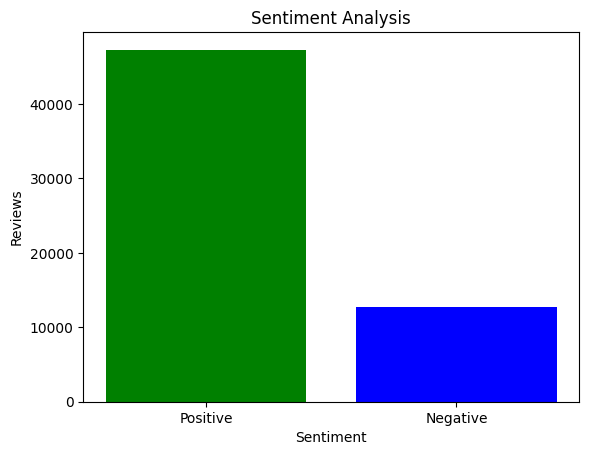

Sentiment Analysis - Positive: 47302, Negative: 12698
Quality: Very Positive


In [32]:
# importing library to plot charts
import matplotlib.pyplot as plt 
  
# x-coordinates of left sides of bars  
left = [100, 200 ] 
  
# heights of bars 
height = [positive,negative] 
  
# labels for bars 
tick_label = ['Positive', 'Negative'] 
  
# plotting a bar chart 
plt.bar(left, height, tick_label = tick_label, width = 80, color = ['green','blue']) 
  
# naming the x-axis 
plt.xlabel('Sentiment') 
# naming the y-axis 
plt.ylabel('Reviews') 
# plot title 
plt.title('Sentiment Analysis') 
  
# function to show the plot 
plt.show() 
print ("Sentiment Analysis - Positive: "+str(positive)+", Negative: "+str(negative))
quality(positive,(positive+negative))

In [33]:
# getting negativity 
negativeity = (negative*100)/(positive+negative)
positivity = (positive*100)/(positive+negative)